# 1-mavzu: O'zbek tili uchun NLP Preprocessing

Ushbu amaliy mashg'ulotda biz o'zbek tili matnlarini qayta ishlashdagi asosiy muammolarni (Kirill/Lotin yozuvlari, turli xil apostroflar) o'rganamiz va o'zimiz yaratgan uznlp kutubxonasini testdan o'tkazamiz.

Darsning asosiy bosqichlari:

- "Xom" ma'lumotlarni yuklash.

- Matndagi sof o'zbek tili matni bo'lmagan qismlarni (HTML teglar, noto'g'ri belgilar) tahlil qilish.

- UzbekNormalizer va Tokenizer modullarini tekshirish.

- To'liq tozalash konveyerini (pipeline) ishga tushirish va natijalarni ko'rish.

In [22]:
import sys
import os
import pandas as pd
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Loyiha manzili: {project_root}")

try:
    from src.uznlp.preprocessing.normalizer import UzbekNormalizer
    from src.uznlp.preprocessing.pipeline import TextPreprocessor
    print("Kutubxona muvaffaqiyatli yuklandi!")
except ImportError as e:
    print(f"Import xatosi: {e}")

Loyiha manzili: c:\Users\Surface PC\OneDrive\Рабочий стол\uznlp_course
Kutubxona muvaffaqiyatli yuklandi!


## Ma'lumotlarni yuklash

Keling, Scraper yordamida yig'ilgan "xom" ma'lumotlarni yuklaymiz. Biz bu yerda Kirill va Lotin yozuvlari aralashgan, ba'zi joylarda HTML teglari qolib ketgan holatlarni ko'rishimiz mumkin.

In [23]:
# Konfiguratsiya faylini yuklash
with open(os.path.join(project_root, 'config/settings.yaml'), 'r') as f:
    config = yaml.safe_load(f)

raw_path = os.path.join(project_root, config['data']['raw_path'])

if os.path.exists(raw_path):
    df = pd.read_csv(raw_path)
    print(f"Yuklangan maqolalar soni: {len(df)} ta")
    display(df.head())
else:
    print("Ma'lumot fayli topilmadi. Iltimos, avval 'collect_data.py' skriptini ishga tushiring.")

Yuklangan maqolalar soni: 39 ta


,url,category,title,body
0,https://kun.uz/news/2025/12/19/kasbiy-talim-tashkilotlarini-akkreditatsiya-qilishda-baholash-indikatorlari-tasdiqlandi,education,Kasbiy ta’lim tashkilotlarini akkreditatsiya qilishda baholash indikatorlari tasdiqlandi,"Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish jarayonida 7 ta yo‘nalish doirasida 37 ta mezon bo‘y..."
1,https://kun.uz/news/2025/12/18/akkreditatsiya-tolovlari-qaytarilmaydi-talim-tashkilotlari-uchun-yangi-qoidalar,education,Akkreditatsiya to‘lovlari qaytarilmaydi: ta’lim tashkilotlari uchun yangi qoidalar,"Hujjatga muvofiq , mazkur nizom o‘rta maxsus, kasbiy, oliy va oliy ta’limdan keyingi ta’lim, shuningdek, kadrlarni qayta tayyorlash va malaka oshi..."
2,https://kun.uz/news/2025/12/23/kunuzda-chiqqan-video-sabab-orzumga-erishdim-harvard-grantini-yutgan-qiz,education,“Kun.uz’da chiqqan video sabab orzumga erishdim” – Harvard grantini yutgan qiz,"Dilafruz Sobirova Farg‘ona shahridagi Prezident maktabining 11-sinf o‘quvchisi. IELTS’dan 8, SAT imtihonidan 1540 ballni qo‘lga kiritgan, nemis ti..."
3,https://kun.uz/news/2025/11/15/maqsadni-katta-qoyib-qorqmaslik-kerak-harvardning-ozbek-magistranti-bilan-suhbat,education,"“Maqsadni katta qo‘yib, qo‘rqmaslik kerak"" – Harvardning o‘zbek magistranti bilan suhbat",Sherzod Omonov Andijon viloyatida tug‘ilib o‘sgan. Hozirda Harvardning huquqshunoslik maktabi magistraturasida o‘qiydi. Sherzod o‘zining muvaffaqi...
4,https://kun.uz/news/2025/12/27/1-yanvardan-maktab-direktorlari-va-orinbosarlariga-kpi-asosida-oylik-ustama-tolanadi,education,1 yanvardan maktab direktorlari va o‘rinbosarlariga KPI asosida oylik ustama to‘lanadi,Maktabgacha va maktab ta’limi sohasida boshqaruv samaradorligini oshirishga qaratilgan hujjatda 2026 yil 1 yanvardan direktor jamg‘armasi hisobida...


## Haqiqiy ma'lumotlar tahlili

O'zbek tili NLPsi uchun eng katta bosh og'riq — bu ikki xil yozuv (Kirill/Lotin) va standartlashmagan belgilar.

Asosiy muammolar:

- Yozuv aralashuvi: Bir matnda ham "Тошкент", ham "Toshkent" uchrashi mumkin.

- Tutuq belgisi (Apostrophe): O‘zbekiston (egri), O'zbekiston (to'g'ri), Ozbekiston` (teskari). Kompyuter uchun bular 3 xil so'z!

- Vebsaytlardan ko'chirilgan matnlardagi HTML belgilar: <br>, &nbsp; kabi teglar modelni chalg'itadi.

In [24]:
# Namuna uchun matn (Kirill, Lotin va HTML aralash)
dirty_text = """
<div class="content">
    Ўзбекистон Республикаси Президентининг <b>фармони</b> эълон қилинди. 
    Bu juda muhim yangilik! O‘zbekiston kelajagi buyuk.
    Sun'iy intellekt — bu kelajak.
</div>
"""

print(dirty_text)


<div class="content">
    Ўзбекистон Республикаси Президентининг <b>фармони</b> эълон қилинди. 
    Bu juda muhim yangilik! O‘zbekiston kelajagi buyuk.
    Sun'iy intellekt — bu kelajak.
</div>



## Normalizer orqali komponentlarni tekshirish

Biz yozgan UzbekNormalizer klassi Kirill yozuvini Lotin yozuviga o'girishi va barcha tutuq belgilarini yagona standartga keltirishi kerak.

"Ўзбекистон" so'zi "O'zbekiston" ga aylanishini tekshirib ko'ramiz.

In [25]:
print(f"Asl holat: {dirty_text[:200]}")

Asl holat: 
<div class="content">
    Ўзбекистон Республикаси Президентининг <b>фармони</b> эълон қилинди. 
    Bu juda muhim yangilik! O‘zbekiston kelajagi buyuk.
    Sun'iy intellekt — bu kelajak.
</div>



In [26]:
normalizer = UzbekNormalizer()

# 1-qadam: Tozalash va Normalizatsiya
clean_1 = normalizer.clean_text_robust(dirty_text)
print(f"Natija:    {clean_1}")

Natija:    bu juda muhim yangilik o'zbekiston kelajagi buyuk sun'iy intellekt bu kelajak


In [27]:
# Tekshirib ko'ramiz
assert "o'zbekiston" in clean_1, "Kirilldan Lotinga o'girishda xatolik!"
assert "<div" not in clean_1, "HTML teglari tozalanmadi!"
print("\n Normalizatsiya testi muvaffaqiyatli o'tdi!")


 Normalizatsiya testi muvaffaqiyatli o'tdi!


In [28]:
clean_1 = clean_1.replace(" b", "").replace("div class content ", "").replace("div", "")
clean_1

"bu juda muhim yangilik o'zbekiston kelajagiuyuk sun'iy intellektu kelajak"

## Tokenizer orqali komponentlarni tekshirish 

Nima uchun oddiy `text.split()` funksiyasidan foydalana olmaymiz?

Oddiy `split`: "O'zbekiston" -> ["O", "'", "zbekiston"]. Bu noto'g'ri, chunki model "O" va "zbekiston"ni alohida so'z deb o'ylaydi.

Bizning Regex Tokenizer: "O'zbekiston" -> ["O'zbekiston"]. Bu to'g'ri yondashuv.

In [29]:
test_word = "O'zbekiston g'ozlari"

print(f"Oddiy Split:      {test_word.split("'")}")

Oddiy Split:      ['O', 'zbekiston g', 'ozlari']


In [30]:
processor = TextPreprocessor(stopwords=[])
print(f"Bizning Tokenizer: {processor.tokenize(test_word)}")

Bizning Tokenizer: ["O'zbekiston", "g'ozlari"]


In [31]:
# Matnni to'liq tokenlarga ajratib ko'ramiz
tokens = processor.tokenize(clean_1)
print(f"\nMatndagi tokenlar ({len(tokens)} ta):")
print(tokens[:10])


Matndagi tokenlar (9 ta):
['bu', 'juda', 'muhim', 'yangilik', "o'zbekiston", 'kelajagiuyuk', "sun'iy", 'intellektu', 'kelajak']


## Full Pipeline va Stop-so'zlar

Endi barcha bosqichlarni birlashtiramiz. Shuningdek, ma'no anglatmaydigan "stop-so'zlar"ni (masalan: va, bilan, uchun) olib tashlaymiz.

In [32]:
# Stop-so'zlarni fayldan yuklash
stopword_path = os.path.join(project_root, config['data']['stopwords_path'])
with open(stopword_path, 'r') as f:
    stopwords = [line.strip() for line in f]

print(f"Yuklangan stop-so'zlar soni: {len(stopwords)} ta. Misollar: {stopwords[:5]}")

# To'liq payplaynni ishga tushirish
full_pipe = TextPreprocessor(stopwords=stopwords)

# Namunaviy matnni qayta ishlash
final_result = full_pipe.process(dirty_text)

print("\n--- YAKUNIY TOZALANGAN MATN ---")
print(final_result)

Yuklangan stop-so'zlar soni: 48 ta. Misollar: ['va', 'ham', 'bilan', 'uchun', 'bu']

--- YAKUNIY TOZALANGAN MATN ---
muhim yangilik o'zbekiston kelajagi buyuk sun'iy intellekt kelajak


In [33]:
# 'body' ustuniga ishlov beramiz
df['clean_text'] = df['body'].apply(full_pipe.process)

# Natijalarni yonma-yon solishtirish
pd.set_option('display.max_colwidth', 100)
display(df[['body', 'clean_text']].head())

,body,clean_text
0,"Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish ja...",hujjatga muvofiq kasbiy ta'lim tashkilotlarini kompleks davlat akkreditatsiyasidan o'tkazish jar...
1,"Hujjatga muvofiq , mazkur nizom o‘rta maxsus, kasbiy, oliy va oliy ta’limdan keyingi ta’lim, shu...",hujjatga muvofiq mazkur nizom o'rta maxsus kasbiy oliy oliy ta'limdan keyingi ta'lim shuningdek ...
2,"Dilafruz Sobirova Farg‘ona shahridagi Prezident maktabining 11-sinf o‘quvchisi. IELTS’dan 8, SAT...",dilafruz sobirova farg'ona shahridagi prezident maktabining 11 sinf o'quvchisi ielts'dan sat imt...
3,Sherzod Omonov Andijon viloyatida tug‘ilib o‘sgan. Hozirda Harvardning huquqshunoslik maktabi ma...,sherzod omonov andijon viloyatida tug'ilib o'sgan hozirda harvardning huquqshunoslik maktabi mag...
4,Maktabgacha va maktab ta’limi sohasida boshqaruv samaradorligini oshirishga qaratilgan hujjatda ...,maktabgacha maktab ta'limi sohasida boshqaruv samaradorligini oshirishga qaratilgan hujjatda 202...


## Haqiqiy ma'lumotlar bilan ishlash

### 1-qadam: Kerakli kutubxonalarni yuklash

Ushbu qismda biz loyiha papkalarini sozlaymiz va o'zimiz yaratgan uznlp kutubxonasini chaqiramiz.

In [34]:
import sys
import os
import pandas as pd
import re
from bs4 import BeautifulSoup

# Loyiha asosiy papkasini (project root) yo'lga qo'shish
# Bu bizga 'src' papkasidagi modullarni import qilish imkonini beradi
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Biz yaratgan maxsus sinflarni yuklaymiz
from src.uznlp.preprocessing.normalizer import UzbekNormalizer
from src.uznlp.preprocessing.pipeline import TextPreprocessor

print("Kutubxonalar muvaffaqiyatli yuklandi!")

Kutubxonalar muvaffaqiyatli yuklandi!


### 2-qadam: Haqiqiy ma'lumotlarni o'qish

Endi `data/raw/uzbek_news.csv` faylidagi yangiliklarni yuklaymiz.

In [35]:
# CSV faylni yuklash
input_path = os.path.join(project_root, 'data/raw/uzbek_news.csv')
df = pd.read_csv(input_path)

print(f"Jami maqolalar soni: {len(df)} ta")
df.head(3)

Jami maqolalar soni: 39 ta


,url,category,title,body
0,https://kun.uz/news/2025/12/19/kasbiy-talim-tashkilotlarini-akkreditatsiya-qilishda-baholash-ind...,education,Kasbiy ta’lim tashkilotlarini akkreditatsiya qilishda baholash indikatorlari tasdiqlandi,"Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish ja..."
1,https://kun.uz/news/2025/12/18/akkreditatsiya-tolovlari-qaytarilmaydi-talim-tashkilotlari-uchun-...,education,Akkreditatsiya to‘lovlari qaytarilmaydi: ta’lim tashkilotlari uchun yangi qoidalar,"Hujjatga muvofiq , mazkur nizom o‘rta maxsus, kasbiy, oliy va oliy ta’limdan keyingi ta’lim, shu..."
2,https://kun.uz/news/2025/12/23/kunuzda-chiqqan-video-sabab-orzumga-erishdim-harvard-grantini-yut...,education,“Kun.uz’da chiqqan video sabab orzumga erishdim” – Harvard grantini yutgan qiz,"Dilafruz Sobirova Farg‘ona shahridagi Prezident maktabining 11-sinf o‘quvchisi. IELTS’dan 8, SAT..."


### 3-qadam: Tozalanmagan matnni ko'zdan kechirish

Keling, birinchi qatordagi matnni olib, uning asl holatini ko'ramiz. Unda HTML kodlar `(<div...>, <b>)`, noto'g'ri formatdagi foizlar `(5,9 foiz)` va turli xil apostroflar `(ta’lim)` mavjudligiga e'tibor bering.

In [36]:
# Birinchi qatordagi matnni olamiz
raw_text = df.iloc[0]['body']

print("--- ASL MATN (TOZALANMAGAN) ---")
print(raw_text)

--- ASL MATN (TOZALANMAGAN) ---
Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish jarayonida 7 ta yo‘nalish doirasida 37 ta mezon bo‘yicha jami 203 ta indikator qo‘llanadi . Shundan: 12 ta (5,9 foiz) majburiy indikator; 191 ta (94,1 foiz) umumiy indikator belgilangan bo‘lib, ular «muvofiq» yoki «muvofiq emas» tarzida baholanadi. Baholash tartibiga ko‘ra: indikatorlarning 50 foizgacha qismi «muvofiq» bo‘lsa — mezon «muvofiq emas»; 50 foiz–60 foiz bo‘lsa — mezon «qisman muvofiq»; 60 foiz va undan yuqori bo‘lsa — mezon «muvofiq» deb topiladi. Qayd etilishicha, majburiy indikator «muvofiq emas» deb baholansa, umumiy natijadan qat’i nazar, tegishli mezon ham «muvofiq emas» deb topiladi.


### 4-qadam: Qadamma-qadam tozalash jarayoni

Bu eng muhim qism. UzbekNormalizer matnni qanday ishlashini bosqichma-bosqich ko'rib chiqamiz.

Asosiy maqsadlar:

- HTML teglarini olib tashlash.

- Buzilgan so'zlarni oldini olish (masalan, O'zbekiston so'zi zbekiston bo'lib qolmasligi kerak).

- Egri qo'shtirnoqlarni (‘) to'g'ri apostrofga (') aylantirish.

In [37]:
normalizer = UzbekNormalizer()

print("--- 1-QADAM: <div class='content'> and <b> kabi HTML taglarni BeautifulSoup yordamida olib tashlash ---")

soup = BeautifulSoup(raw_text, "html.parser")
step1_text = soup.get_text(separator=" ")
print("\n", step1_text[:200] + "...") 

--- 1-QADAM: <div class='content'> and <b> kabi HTML taglarni BeautifulSoup yordamida olib tashlash ---

 Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish jarayonida 7 ta yo‘nalish doirasida 37 ta mezon bo‘yicha jami 203 ta indikator qo‘llanadi . Shundan: 12 ta...


In [38]:
print("--- 2-QADAM: Apostroflarni to'g'irlab chiqish ---")
# (‘ ’) kabi belgilarni standard to'g'ri tutuq belgisiga (') aylantirmiz
# Misol uchun "o‘tkazish" -> "o'tkazish"
step2_text = re.sub(r"[\u2018\u2019\u02BB\u02BC\u0060]", "'", step1_text)
print("\n", step2_text[:200] + "...")

--- 2-QADAM: Apostroflarni to'g'irlab chiqish ---

 Hujjatga muvofiq, kasbiy ta'lim tashkilotlarini kompleks davlat akkreditatsiyasidan o'tkazish jarayonida 7 ta yo'nalish doirasida 37 ta mezon bo'yicha jami 203 ta indikator qo'llanadi . Shundan: 12 ta...


In [39]:
print("--- 3 QADAM: Harflarni kichiklashtirish va Regex yordamida matnni tozalash ---")
step3_text = step2_text.lower()
step3_text = re.sub(r"[^a-z0-9'‘’\s]", ' ', step3_text)
step3_text = re.sub(r'\s+', ' ', step3_text).strip()
print("\n", step3_text[:200] + "...")

--- 3 QADAM: Harflarni kichiklashtirish va Regex yordamida matnni tozalash ---

 hujjatga muvofiq kasbiy ta'lim tashkilotlarini kompleks davlat akkreditatsiyasidan o'tkazish jarayonida 7 ta yo'nalish doirasida 37 ta mezon bo'yicha jami 203 ta indikator qo'llanadi shundan 12 ta 5 9...


### 5-qadam: To'liq Pipeline'ni ishga tushirish

Mantiq to'g'ri ishlagani uchun, endi barcha maqolalarga TextPreprocessorni qo'llaymiz. Bu jarayonda `stopwords` (ahamiyatsiz so'zlar) ham olib tashlanadi.

In [40]:
# Stopwords ro'yxatini yuklash
stopwords_path = os.path.join(project_root, 'data/stopwords.txt')
if os.path.exists(stopwords_path):
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stopwords_list = [line.strip() for line in f]
else:
    stopwords_list = []
    print("Ogohlantirish: Stopwords fayli topilmadi!")

# Processorni ishga tushirish
processor = TextPreprocessor(stopwords=stopwords_list)

# Barcha qatorlarga qo'llash
print("Barcha maqolalar tozalanmoqda...")
df['clean_text'] = df['body'].fillna("").apply(processor.process)

# Natijani solishtirish
pd.set_option('display.max_colwidth', 150)
df[['body', 'clean_text']].head(2)

Barcha maqolalar tozalanmoqda...


,body,clean_text
0,"Hujjatga muvofiq, kasbiy ta’lim tashkilotlarini kompleks davlat akkreditatsiyasidan o‘tkazish jarayonida 7 ta yo‘nalish doirasida 37 ta mezon bo‘y...",hujjatga muvofiq kasbiy ta'lim tashkilotlarini kompleks davlat akkreditatsiyasidan o'tkazish jarayonida ta yo'nalish doirasida 37 ta mezon bo'yich...
1,"Hujjatga muvofiq , mazkur nizom o‘rta maxsus, kasbiy, oliy va oliy ta’limdan keyingi ta’lim, shuningdek, kadrlarni qayta tayyorlash va malaka oshi...",hujjatga muvofiq mazkur nizom o'rta maxsus kasbiy oliy oliy ta'limdan keyingi ta'lim shuningdek kadrlarni qayta tayyorlash malaka oshirish tashkil...


### 6-qadam: Natijani vizual tekshirish (WordCloud)

Tozalangan matn sifatini tekshirish uchun eng ko'p ishlatilgan so'zlarni chizib ko'ramiz. Agar tozalash to'g'ri bo'lsa, biz bu yerda `va, bilan` kabi so'zlarni yoki HTML kodlarni ko'rmasligimiz kerak.

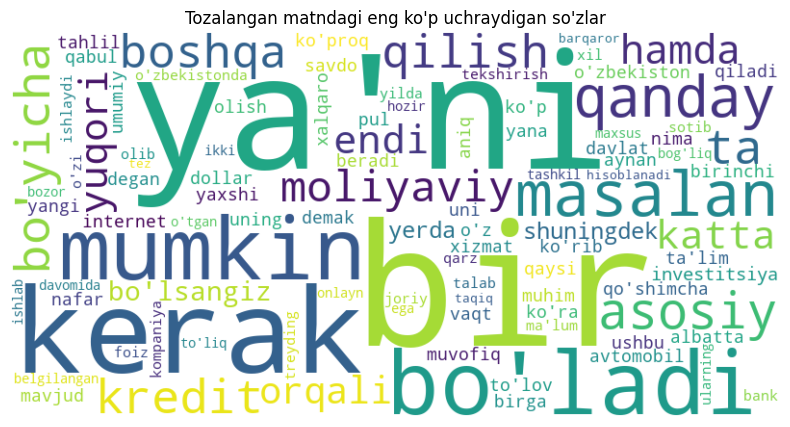

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Barcha tozalangan matnlarni birlashtiramiz
text_combined = " ".join(df['clean_text'])

# WordCloud yaratish
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=100
).generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Tozalangan matndagi eng ko'p uchraydigan so'zlar")
plt.show()

### 7-QADAM: Stemmingni vizualizatsiya qilish

Keling bir nechta murakkab so'zlarni olamiz va `UzbekStemmerLib` ularni qanday "stem"larini olishini ko'ramiz.

In [42]:
try:
    from src.uznlp.preprocessing.stemmer_lib import UzbekStemmerLib
    stemmer = UzbekStemmerLib()
    method_name = "UzMorphAnalyser Library"
except:
    from src.uznlp.preprocessing.stemmer import UzbekStemmer
    stemmer = UzbekStemmer()
    method_name = "Custom Rule-Based"

print(f"Using Stemmer: {method_name}")

# Test Words
test_words = [
    "maktablarimizda",  
    "o'quvchilarining",
    "kitoblarni",
    "kelajagi",
    "boraman",
    "shahridagi"
]

results = []
for word in test_words:
    results.append({
        "Original": word,
        "Stemmed": stemmer.stem(word)
    })

pd.DataFrame(results)

Using Stemmer: UzMorphAnalyser Library


,Original,Stemmed
0,maktablarimizda,maktab
1,o'quvchilarining,o‘quvchi
2,kitoblarni,kitob
3,kelajagi,kelajag
4,boraman,bor
5,shahridagi,shahr


c:\Users\Surface PC\OneDrive\Рабочий стол\uznlp_course\venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bo', 'lgan', 'lib', 'lsa', 'ng', 'sha', 'so', 'yo'] not in stop_words.
  warnings.warn(


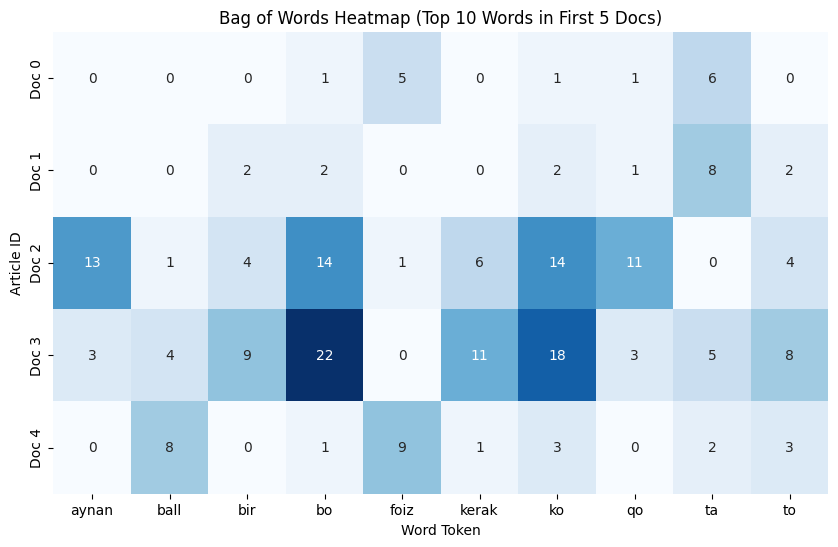

In [43]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# 1. Vizualizatsiya uchun mini-vektorizatorni ishga tushiramiz
# Grafik ekranga mos kelishi uchun biz faqat eng yaxshi 10 ta so'zni olamiz
mini_vec = CountVectorizer(max_features=10, stop_words=list(stopwords_list))

# 2. Faqat dastlabki 5 ta hujjatga mos keladi
subset_text = df['clean_text'].iloc[:5]
matrix = mini_vec.fit_transform(subset_text)

# 3. Chizish uchun DataFrame yarating
dense_df = pd.DataFrame(matrix.toarray(), columns=mini_vec.get_feature_names_out())
dense_df.index = [f"Doc {i}" for i in range(5)]

# 4. Issiqlik xaritasi (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(dense_df, annot=True, cmap="Blues", cbar=False)
plt.title("Bag of Words Heatmap (Top 10 Words in First 5 Docs)")
plt.ylabel("Article ID")
plt.xlabel("Word Token")
plt.show()